In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [2]:
# read training data
data = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv',header=None)
data.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
# finding total null values and deleting them
data.isna().sum()

0      0
1      0
2      0
3    686
dtype: int64

In [4]:
data.dropna(inplace=True)
data.shape

(73996, 4)

In [5]:
# finding value count of each response in column 2
data[2].value_counts()

Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: 2, dtype: int64

In [6]:
# deleting the irrelevent reviews because it will help to find the sentiment
data_2 = data[data[2]!='Irrelevant']
data_2.shape

(61121, 4)

In [7]:
# drop column 0 & 1 for now as it will not be helpfull to find sentiment
data_2.drop(columns=[0,1],inplace=True)
data_2.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,2,3
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
# printing a value of new data to check how is sentence defined
data_2.iloc[1000,1]

'Eli Whitney Roth International is making a movie based loosely on using the game,.. bit. ly / on 2wv4KHM'

In [9]:
# importing libraries for data cleaning
from bs4 import BeautifulSoup 
import re
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# removing not and no from stop words as we need them for our model training
stopwords = stopwords.words("english")
stopwords.remove('not')
stopwords.remove('no')

# intializing method for lemmatizing words
lemmatizer = WordNetLemmatizer()

# now creating funtion to clean our data
def cleaned_review(review):
    # remove any html tags
    new_review = BeautifulSoup(review).get_text()
    
    # remove urls from reviews
    no_urls = new_review.replace('http\S+', '').replace('www\S+', '')
    
    # remove any non-letters
    clean_review = re.sub("[^a-zA-Z]", " ", no_urls)
    
    # convert whole sentence to lowercase and split
    new_words = clean_review.lower().split()
    
    # converting stopwords list to set for faster search
    stops = set(stopwords)
    
    # using stopwords to remove irrelavent words and lemmatizing the final output
    final_words = [lemmatizer.lemmatize(word) for word in new_words if not word in stops]
    
    # return the final result
    return (" ".join(final_words))

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [10]:
# now we will use our funtion to get cleaned data and no. of words
data_2['msg'] = data_2[3].apply(lambda x:cleaned_review(x))

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
# comparing our cleaned data with original
print(data_2.iloc[1000,1])
print(data_2.iloc[1000,2])

Eli Whitney Roth International is making a movie based loosely on using the game,.. bit. ly / on 2wv4KHM
eli whitney roth international making movie based loosely using game bit ly wv khm


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


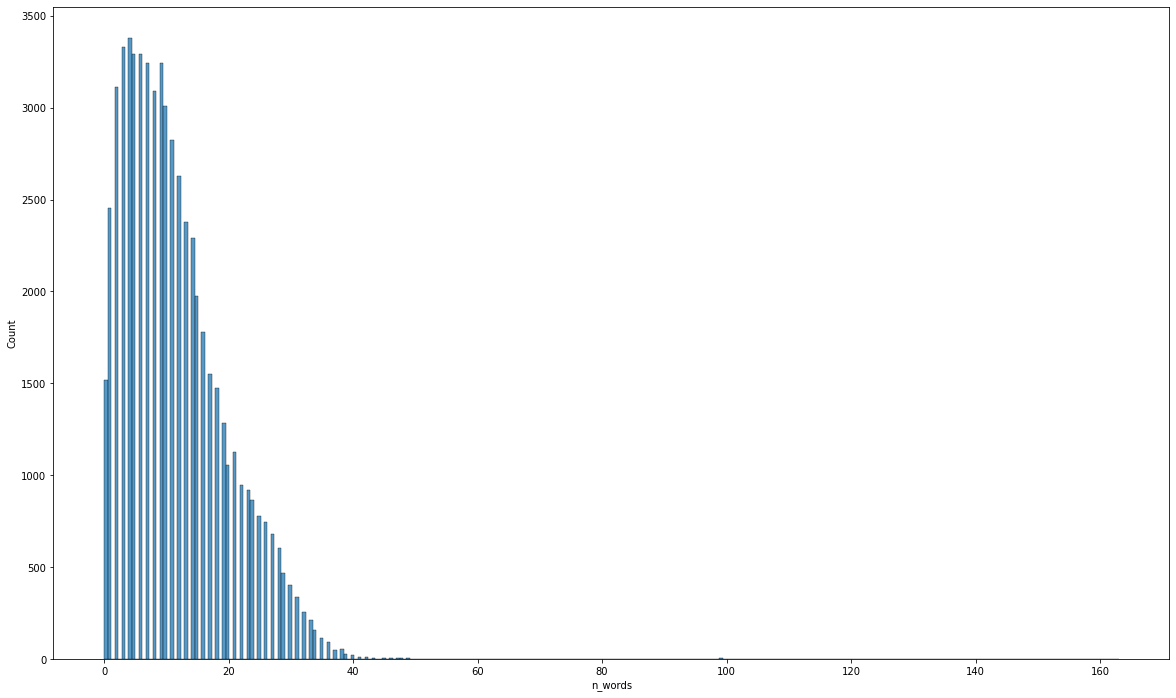

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(20, 12))
# finding ideal length to use for further process
data_2['n_words'] = data_2['msg'].apply(lambda x:len(x.split()))
sns.histplot(data = data_2, x='n_words')
plt.show()

In [13]:
# so we see above that max no.of words in each sentence is 40
max_len = 40

In [14]:
# now we need to one_hot encode the reviews
sentiment = pd.get_dummies(data_2[2])
data_3 = pd.concat([data_2,sentiment],axis=1)
data_3.head()

,2,3,msg,n_words,Negative,Neutral,Positive
0,Positive,im getting on borderlands and i will murder yo...,im getting borderland murder,4,0,0,1
1,Positive,I am coming to the borders and I will kill you...,coming border kill,3,0,0,1
2,Positive,im getting on borderlands and i will kill you ...,im getting borderland kill,4,0,0,1
3,Positive,im coming on borderlands and i will murder you...,im coming borderland murder,4,0,0,1
4,Positive,im getting on borderlands 2 and i will murder ...,im getting borderland murder,4,0,0,1


In [15]:
# drop columns no longer needed 
data_3.drop(columns=[2,3,'n_words'],inplace=True)

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# now we will tokenize the words to sequence so that our model can understand
# we will also pad the sentences with less than 40 words to make size of each sentence equal
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_3['msg'].values)
sequences = tokenizer.texts_to_sequences(data_3['msg'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = pad_sequences(sequences, maxlen=max_len, padding='post')

Found 23091 unique tokens.


In [17]:
# lets see how is our output
# here 0's at ending are defined due to the padding
X[1000]

array([ 2107, 18661,  4716,  1599,   227,   495,   371, 17624,   298,
           1,   179,   192,  4724,  7703,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [18]:
# for target we will take postive, negative and neutral columns from data_3
y=data_3[['Negative','Neutral','Positive']]
y.shape

(61121, 3)

In [19]:
from sklearn.model_selection import train_test_split

# splitting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
X_train.shape,X_test.shape

((60509, 40), (612, 40))

In [20]:
# initialize libraries for model creation
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, SpatialDropout1D, Embedding, LSTM
model = Sequential()

2022-08-07 15:33:06.673731: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [21]:
# now we create our model
# here n_most_words = 23091(vocab_size)+1
n_most_words = 23092
n_dim = 50
model.add(Embedding(n_most_words,n_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50,dropout=0.25,recurrent_dropout=0.25))
model.add(Dense(25,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 50)            1154600   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 50)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 78        
Total params: 1,176,153
Trainable params: 1,176,153
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(patience=5)
model_history = model.fit(X_train,y_train,epochs=30,validation_split = 0.1, batch_size = 128 ,callbacks=[checkpoint,early_stop])

Epoch 1/30


2022-08-07 15:33:07.132543: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


426/426 [==============================] - 74s 163ms/step - loss: 0.9668 - acc: 0.4879 - val_loss: 0.7614 - val_acc: 0.6667
Epoch 2/30
426/426 [==============================] - 69s 161ms/step - loss: 0.5647 - acc: 0.7784 - val_loss: 0.4548 - val_acc: 0.8285
Epoch 3/30
426/426 [==============================] - 69s 162ms/step - loss: 0.3719 - acc: 0.8647 - val_loss: 0.3806 - val_acc: 0.8569
Epoch 4/30
426/426 [==============================] - 70s 163ms/step - loss: 0.3040 - acc: 0.8873 - val_loss: 0.3883 - val_acc: 0.8658
Epoch 5/30
426/426 [==============================] - 68s 159ms/step - loss: 0.2679 - acc: 0.9013 - val_loss: 0.3427 - val_acc: 0.8732
Epoch 6/30
426/426 [==============================] - 68s 160ms/step - loss: 0.2418 - acc: 0.9078 - val_loss: 0.3374 - val_acc: 0.8810
Epoch 7/30
426/426 [==============================] - 69s 163ms/step - loss: 0.2214 - acc: 0.9137 - val_loss: 0.3396 - val_acc: 0.8784
Epoch 8/30
426/426 [==============================] - 68s 160ms/st

In [23]:
# checking the model loss and accuracy
model.load_weights('weights.hdf5')
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

20/20 [==============================] - 1s 28ms/step - loss: 0.2788 - acc: 0.9052
Test set
  Loss: 0.279
  Accuracy: 0.905


In [24]:
# visualizing the result 
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

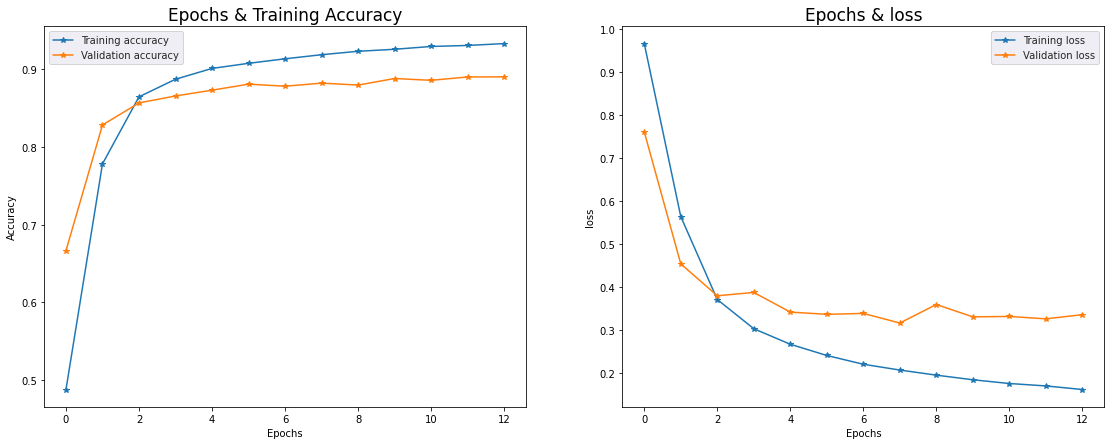

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, '*-',label = 'Training accuracy')
ax[0].plot(val_acc, '*-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, '*-',label = 'Training loss')
ax[1].plot(val_loss, '*-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

In [26]:
# defining funtion to give us prediction of a sentence 
def find_sentiment(review):
    seq = tokenizer.texts_to_sequences(review)
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)
    label = ['Negative','Neutral','Positive']
    return label[np.argmax(pred)]

In [27]:
# checking with taining data
data.iloc[1000]

0                                                 2578
1                                          Borderlands
2                                             Negative
3    @ EpicGames @ 2K @ Steam Why add a crossplay f...
Name: 1004, dtype: object

In [28]:
# here we can find our output
print(find_sentiment(["@ EpicGames @ 2K @ Steam Why add a crossplay for @ Borderlands 3 if you're not going to make it compatible for the console?"]))

Negative


In [29]:
v_data = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv',header=None)
v_data.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [30]:
# removing irrelavent from column 2 as we didnt use those to predict
v_data = v_data[v_data[2]!='Irrelevant']

In [31]:
# finding the final prediction on validation set
v_data['predicted'] = v_data[3].apply(lambda x:find_sentiment([x]))
v_data.head(20)

,0,1,2,3,predicted
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,Negative
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,Negative
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",Negative
4,4433,Google,Neutral,Now the President is slapping Americans in the...,Neutral
5,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,Negative
6,7925,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...,Positive
7,11332,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ...",Positive
8,1107,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...,Negative
9,2069,CallOfDuty,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...,Negative
10,3185,Dota2,Positive,The professional dota 2 scene is fucking explo...,Positive
